In [3]:
import arviz as az
import pymc as pm
# import arviz.labels as azl

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import matplotlib as mpl
import warnings
import numpy as np
warnings.simplefilter(action='ignore', category=FutureWarning)

## Reestimate model because of pickle problems

In [6]:
def gamma(alpha, beta):
    def g(x):
        return pm.Gamma(x, alpha=alpha, beta=beta)
    return g

def hcauchy(beta):
    def g(x):
        return pm.HalfCauchy(x, beta=beta)
    return g


def fit_gp(y, X, l_prior, eta_prior, sigma_prior, kernel_type='M52', bayes_kws=dict(draws=1000, tune=1000, chains=2, cores=1), prop_Xu=None):
    """
    function to return a pymc3 model
    y : dependent variable
    X : independent variables
    prop_Xu : number of inducing varibles to use. If None, use full marginal likelihood. If not none, use FTIC. 
    bayes_kw : kws for pm.sample
    X, y are dataframes. We'll use the column names. 
    """
    kernel_type = kernel_type.lower()
    with pm.Model() as model:
        # Covert arrays
        X_a = X.values
        y_a = y.values.flatten()
        X_cols = list(X.columns)

        
        # Kernels
        # 3 way interaction
        eta = eta_prior('eta')
        cov = eta**2
        for i in range(X_a.shape[1]):
            var_lab = 'l_'+X_cols[i]
            if kernel_type=='rbf':
                cov = cov*pm.gp.cov.ExpQuad(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='exponential':
                cov = cov*pm.gp.cov.Exponential(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='m52':
                cov = cov*pm.gp.cov.Matern52(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='m32':
                cov = cov*pm.gp.cov.Matern32(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])

        # Covariance model
        cov_tot = cov 
        
        # Noise model
        sigma_n =sigma_prior('sigma_n')

        # Model
        if not (prop_Xu is None):
            # Inducing variables
            num_Xu = int(X_a.shape[0]*prop_Xu)
            Xu = pm.gp.util.kmeans_inducing_points(num_Xu, X_a)
            gp = pm.gp.MarginalSparse(cov_func=cov_tot, approx="FITC")
            y_ = gp.marginal_likelihood('y_', X=X_a, y=y_a, Xu=Xu, noise=sigma_n)
        else:
            gp = pm.gp.Marginal(cov_func=cov_tot)
            y_ = gp.marginal_likelihood('y_', X=X_a, y=y_a, noise=sigma_n)
            
        
        if not (bayes_kws is None):
            trace = pm.sample(**bayes_kws)
            result = trace
        else:
            mp = pm.find_MAP()
            result = mp
    
    return gp, result, model

In [11]:
root_path = '1fme/sensitivity'

models = []
for feat, trans, kernel in [['dihedrals', None, 'exponential'], ['distances', 'linear', 'exponential'], ['distances', 'logistic', 'exponential']]:

    results_path = Path(root_path).joinpath(f"{feat}_{trans}_{kernel}.pkl")

    results = pickle.load(results_path.open('rb'))
    data_s = results['data']
    y, X = data_s.iloc[:, [0]], data_s.iloc[:, 1:]
    bayes_kws = dict(draws=5000, tune=1000, chains=4, cores=4, target_accept=0.90)


    # Fit model
    l_prior = gamma(2, 0.5)
    eta_prior = hcauchy(2)
    sigma_prior = hcauchy(2)
    gp, trace, model = fit_gp(y=y, X=X,  # Data
                                    l_prior=l_prior, eta_prior=eta_prior, sigma_prior=sigma_prior,  # Priors
                                    kernel_type=kernel,  # Kernel
                                    prop_Xu=None,  # proportion of data points which are inducing variables.
                                    bayes_kws=bayes_kws)  #
    models.append((gp, trace, model))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, l_dim, l_lag, l_states, sigma_n]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 141 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, l_scheme[T.closest-heavy], l_dim, l_lag, l_states, sigma_n]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 207 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, l_scheme[T.closest-heavy], l_dim, l_lag, l_states, l_steep, l_cent, sigma_n]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 907 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8074, but should be close to 0.9. Try to increase the number of tuning steps.


In [53]:
from copy import deepcopy


var_name_map_1={"l_states": r"Num. states", 
            "l_dim": r"Num. dims", 
            "l_lag": r"$\tau_{tICA}$"}

var_name_map_2 = deepcopy(var_name_map_1)
var_name_map_2.update({"l_cent": r"Centre", 
             "l_steep": r"Steepness"})


maps = [var_name_map_1, var_name_map_1, var_name_map_2]
             

In [74]:
traces = [deepcopy(x[1]) for x in models]
traces   = [x.rename_vars(maps[i]) for i, x in enumerate(traces)]

Relevance

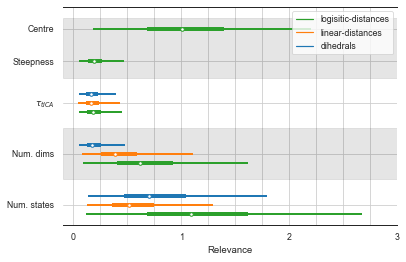

In [112]:
def R(x): 
    return 1/x
    
with sns.plotting_context('paper'):
    sns.set_style('white')
    
    fig, ax = plt.subplots(1)
    
    ax.set_xlabel("Relevance")
    
    pm.plot_forest(traces, 
                   model_names=['dihedrals','linear-distances', 'logisitic-distances'], 
                   combined=True, 
                   linewidth=2, 
                   var_names=[ r"Centre", r"Steepness", r"$\tau_{tICA}$", r"Num. dims", r"Num. states"], 
                   transform=R, 
                   ax=ax, 
                   hdi_prob=0.95, legend=True)
    
    ax.set_title('')
    ax.set_xlim(-0.1, 3)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
    
    ax.grid(which='both')
    plt.savefig(Path(root_path).joinpath('forestplot.pdf'), bbox_inches='tight')
    


In [ ]:
# def R(x):
#     return 1/x

# features = ['dihedrals', 'distances_linear', 'distances_logistic']
# feature_names = ['Dihedrals', 'Distances', 'logistic(Distances)']

# inp_dir = 'sensitivities_exp_log_outcome'


# relevance_vars = ["l_tica__lag_s","l_tica__dim_s", "l_cluster__k_s", "l_distances__centre_s", "l_distances__steepness_s"]


# info_share_vars =["l_distances__scheme[closest-heavy]_s", "l_distances__scheme[ca]_s"]




# def make_labeller(labels):
#     var_name_map={"l_cluster__k_s": r"$n$", 
#                 "l_tica__dim_s": r"$m$", 
#                 "l_tica__lag_s": r"$\tau_{tICA}$",
#                 "l_distances__scheme[closest-heavy]_s": "$X-X$", 
#                 "l_distances__scheme[ca]_s": r"$C\alpha-C\alpha$", 
#                  "l_distances__centre_s": r"$cent.$", 
#                  "l_distances__steepness_s": r"$steep.$"}
                  
#     def labeller(pos, x):
#         label = labels[x]
#         old_text = label.get_text()

#         if '__' in old_text:
#             var = old_text.split(':')[-1].strip()
#             new_var = var_name_map[var]
#             new_txt = f"{old_text.split(':')[0]} : {new_var}" 
#         else:
#             new_txt = old_text
#         return new_txt
    
#     return labeller


# def get_model_names(paths):
#     model_names = []
#     for x in paths:
#         text = np.array(str(x.stem).split('_'))
#         outcome_ix = np.where((text=='timescale') | (text == 'vamp'))[0][0]
#         outcome = text[outcome_ix]
#         if outcome == 'timescale':
#             num_its = text[outcome_ix+2]
#             outcome = f'$t_{{{num_its}}}$'
#         if outcome == 'vamp':
#             outcome = outcome.upper()
#         model_names.append(outcome) 
#     return model_names

# def get_traces(paths):
#     all_models = [pickle.load(x.open('rb')) for x in paths]
#     all_traces = [x['trace'] for x in all_models]
#     all_traces = [az.from_pymc3(trace=x)['posterior'] for x in all_traces]    
#     return all_traces


# def add_null_variables(trace, var_names):

#     for var_name in var_names:
#         trace = trace.assign({var_name: lambda x: x.sigma_n*0})
#     return trace
        
    
# def add_variables_to_traces(traces, all_var_names):
#     tmp = []
#     for trace in traces: 
#         var_names = set([x for x in trace.data_vars.keys()])
#         missing_vars = list(set(all_var_names) - var_names)
#         trace = add_null_variables(trace, missing_vars)
#         tmp.append(trace)
#     return tmp
        
        



# for protein in ['uvf']: #funcs.PROTEIN_DIRS[:8]:
#     with sns.plotting_context('paper', font_scale=1):
        
#         annotate_kws = dict(xycoords='axes fraction', va='top', ha='left', 
#                     bbox={'facecolor': 'w', 'alpha': 0.5, 'edgecolor': 'w'})
        
#         fig = plt.figure(constrained_layout=True, figsize=(6, 8))
#         widths = [1, 1, 1]
#         heights = [4, 2]
#         spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths,
#                                   height_ratios=heights)
        
#         axes = np.empty((len(heights), len(widths)), dtype=object)
#         for i in range(len(heights)):
#             for j in range(len(widths)):
#                 if j > 0:
#                     axes[i, j] = fig.add_subplot(spec[i, j], sharey=axes[i, 0], sharex=axes[i, 0])
#                     plt.setp(axes[i, j].get_yticklabels(), visible=False)
#                 if j == 0: 
#                     axes[i,j] = fig.add_subplot(spec[i, j])
                    
#         LETTERS = ['a', 'b', 'c', '', 'd', 'e', 'f']
#         let_count = 0
#         for feat_ix, feature in enumerate(features):
            
#             # Get the paths
#             timescale_paths = list(Path(inp_dir).glob(f"{protein}_{feature}_timescale_its*"))
#             timescale_paths.sort()
#             vamp_path = list(Path(inp_dir).glob(f"{protein}_{feature}_vamp_sensitivity*.pkl"))[0]
#             all_model_paths = [vamp_path]+timescale_paths

#             if len(timescale_paths) > 0:
                
# #                 print(protein, feature)
#                 # Get model names
#                 model_names = get_model_names(all_model_paths)
#                 all_traces = get_traces(all_model_paths)
                
                
#                 vars_to_add = relevance_vars+info_share_vars
#                 all_traces = add_variables_to_traces(all_traces, vars_to_add)
                
#                 # Plot relevances: 
#                 ax = axes[0, feat_ix]
#                 pm.plot_forest(all_traces, model_names=model_names, 
#                                combined=True, linewidth=2, 
#                        var_names=relevance_vars, transform=R, ax=ax, hdi_prob=0.95)
#                 ax.grid()
#                 ax.set_title(None)
#                 ax.set_xlabel("Relevance")
                
#                 ax.annotate(text=f"({LETTERS[feat_ix]}) {feature_names[feat_ix]}",xy=(0.01, 0.98), **annotate_kws)
#                 let_count += 1
                
#                 ax.set_xscale('log')
                
#                 # Adjust axes labels
#                 if feat_ix == 2:
#                     labels = axes[0, 0].yaxis.get_majorticklabels()
#                     labeller = make_labeller(labels)
#                     ax.yaxis.set_major_formatter(labeller)
                
                
#                 # Plot infor sharing: 
#                 ax = axes[1, feat_ix]
#                 pm.plot_forest(all_traces, model_names=model_names, 
#                                combined=True, linewidth=2, 
#                        var_names=info_share_vars, ax=ax, hdi_prob=0.95)
#                 ax.grid()
#                 ax.set_xlabel("Information sharing")
                
#                 if feature_names[feat_ix] != 'Dihedrals':
#                     ax.annotate(text=f"({LETTERS[feat_ix+len(features)]}) {feature_names[feat_ix]}",xy=(0.01, 0.97),  **annotate_kws)
                    
#                 ax.set_title(None)
#                 ax.set_xscale('log')

#                 # Plot information sharing
                
#                 # Adjust axes labels
#                 if feat_ix == 2:
#                     labels = axes[1, 0].yaxis.get_majorticklabels()
#                     labeller = make_labeller(labels)
#                     ax.yaxis.set_major_formatter(labeller)                

# #         plt.tight_layout()
#         plt.savefig(funcs.FIG_DIR.joinpath(f'sensitivities/{protein}_sensitivity.pdf'), bbox_inches='tight')

# all_model_paths